In [1]:
from zipfile import ZipFile
from pathlib import Path
import napari
from napari.utils import nbscreenshot
import time
from shapely.geometry import GeometryCollection
from shapely.geometry import Point
from skimage.transform import AffineTransform
import dask.array as da
from dask.array.core import normalize_chunks
from scipy.ndimage import affine_transform
from functools import partial
# 
from utils.download_sample import download_from_dropbox
from utils.coordinate_utils import extract_coordinates, normalize_coords_to_pixel
from utils.imutils import *
from utils.shapely_and_napari_utils import *
from utils.chunks import get_chunk_coordinates, get_rect_from_chunk_slice, tile_chunk_intersections
from fuse.fuse import fuse_func

In [2]:
%gui qt

In [3]:
time.sleep(1)

In [4]:
if not Path("Stiching_Example_Dataset").exists():
    # Download and extract sample data
    example_dataset="https://www.dropbox.com/s/rhggl54sbpx9llj/Stiching_Example_Dataset.zip?dl=0"
    print("Downloading sample file from dropbox")
    download_from_dropbox(example_dataset, "_sample.zip")
    print("Extracting sample file")
    ZipFile("_sample.zip").extractall()

In [5]:
coords = extract_coordinates("Stiching_Example_Dataset/out.txt")
coords

,name,X,Y,Z,um/px
0,1_0000,3582.7,4164.4,1686.65,0.64
1,1_0001,-12396.6,11719.3,1686.63,0.64
2,1_0002,-13583.0,11726.0,1686.63,0.64
3,1_0003,-14769.3,11732.8,1686.63,0.64
4,1_0004,-15955.6,11739.5,1686.63,0.64
...,...,...,...,...,...
67,1_0067,-16003.1,3370.3,1686.63,0.64
68,1_0068,-14816.8,3363.5,1686.63,0.64
69,1_0069,-13630.5,3356.8,1686.63,0.64
70,1_0070,-12444.2,3350.1,1686.63,0.64


In [6]:
files = sorted(list(Path("Stiching_Example_Dataset").glob("*.jpg")))

In [7]:
normalized_coords=normalize_coords_to_pixel(coords).to_numpy()

In [8]:
input_transforms = [crop_black_border, 
                    transpose]
_load_image = partial(load_image, transforms=input_transforms)

In [9]:
tile_shape=_load_image(str(files[0])).shape
tile_shape

bboxes = []
transforms = []
# skip first image as it is an outlier (stage position wise)
for coord in normalized_coords[1:]:
    translate = AffineTransform(translation=coord)
    bboxes.append(
        get_transformed_bbox(tile_shape[:2], translate.params))
    transforms.append(translate.params)

In [10]:
mosaic = GeometryCollection([napari_shape_to_shapely(s) for s in bboxes])

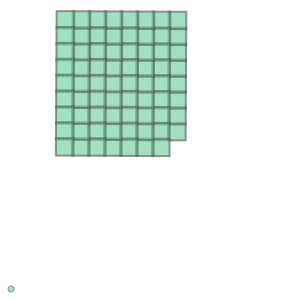

In [11]:
origin = Point(0,0)
GeometryCollection((origin, mosaic))

### Move to origin
Find the translation that moves the stitched area to the origin and determine the size of the Zarr array we require.

In [12]:
all_bboxes = np.vstack(bboxes)
# minimum  & maximum extents of tile collection
all_min = all_bboxes.min(axis=0)
all_max = all_bboxes.max(axis=0)
stitched_shape=tuple(np.ceil(all_max-all_min).astype(np.int))

stitched_shape

<ipython-input-12-77957b7587ec>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  stitched_shape=tuple(np.ceil(all_max-all_min).astype(np.int))


(16925, 15222)

In [13]:
shift_to_origin = AffineTransform(translation=-all_min)
shift_to_origin.params

array([[ 1.00000000e+00, -0.00000000e+00,  3.24193750e+04],
       [ 0.00000000e+00,  1.00000000e+00, -5.22390625e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [14]:
# shift all layers of mosaic
transforms = [t @ shift_to_origin.params for t in transforms ]

In [15]:
shifted_bboxes = []
for t, coord in zip(transforms,
                    normalized_coords[1:]):
    shifted_bboxes.append(
        get_transformed_bbox(tile_shape, t))
shifted_bboxes

[array([[13049.6875, 13087.5   ],
        [15081.6875, 13087.5   ],
        [15081.6875, 15147.5   ],
        [13049.6875, 15147.5   ]]),
 array([[11195.9375 , 13097.96875],
        [13227.9375 , 13097.96875],
        [13227.9375 , 15157.96875],
        [11195.9375 , 15157.96875]]),
 array([[ 9342.34375, 13108.59375],
        [11374.34375, 13108.59375],
        [11374.34375, 15168.59375],
        [ 9342.34375, 15168.59375]]),
 array([[ 7488.75  , 13119.0625],
        [ 9520.75  , 13119.0625],
        [ 9520.75  , 15179.0625],
        [ 7488.75  , 15179.0625]]),
 array([[ 5635.15625, 13129.6875 ],
        [ 7667.15625, 13129.6875 ],
        [ 7667.15625, 15189.6875 ],
        [ 5635.15625, 15189.6875 ]]),
 array([[ 3781.5625 , 13140.15625],
        [ 5813.5625 , 13140.15625],
        [ 5813.5625 , 15200.15625],
        [ 3781.5625 , 15200.15625]]),
 array([[ 1927.96875, 13150.625  ],
        [ 3959.96875, 13150.625  ],
        [ 3959.96875, 15210.625  ],
        [ 1927.96875, 15210.625 

In [16]:
mosaic_shifted = GeometryCollection([napari_shape_to_shapely(s) for s in shifted_bboxes])

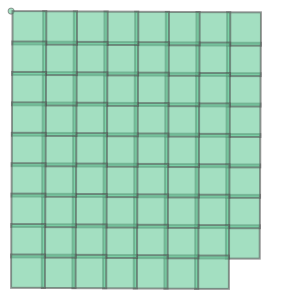

In [17]:

origin = Point(0,0)
GeometryCollection((origin, mosaic_shifted))

## Create a dask array

In [18]:
chunk_size = (4096,4096)

In [19]:
#input_dtype = mosaic_layers[0].data.dtype
#target_array = da.zeros(stitched_shape, dtype=input_dtype, chunks=(4000, 4000))
#target_array.chunks
chunks = normalize_chunks((4096,4096),shape=tuple(stitched_shape))
chunks

((4096, 4096, 4096, 4096, 541), (4096, 4096, 4096, 2934))

In [20]:
# sanity check
computed_shape = np.array(list(map(sum, chunks)))
assert np.all(np.array(stitched_shape) == computed_shape)

In [21]:
chunk_slices = list(get_chunk_coordinates(stitched_shape, chunk_size))
chunk_slices

[((0, 4096), (0, 4096)),
 ((0, 4096), (4096, 8192)),
 ((0, 4096), (8192, 12288)),
 ((0, 4096), (12288, 15222)),
 ((4096, 8192), (0, 4096)),
 ((4096, 8192), (4096, 8192)),
 ((4096, 8192), (8192, 12288)),
 ((4096, 8192), (12288, 15222)),
 ((8192, 12288), (0, 4096)),
 ((8192, 12288), (4096, 8192)),
 ((8192, 12288), (8192, 12288)),
 ((8192, 12288), (12288, 15222)),
 ((12288, 16384), (0, 4096)),
 ((12288, 16384), (4096, 8192)),
 ((12288, 16384), (8192, 12288)),
 ((12288, 16384), (12288, 15222)),
 ((16384, 16925), (0, 4096)),
 ((16384, 16925), (4096, 8192)),
 ((16384, 16925), (8192, 12288)),
 ((16384, 16925), (12288, 15222))]

In [22]:
chunk_shapes = list(map(get_rect_from_chunk_slice, chunk_slices))

In [23]:
chunks_shapely = GeometryCollection([napari_shape_to_shapely(c) for c in chunk_shapes])

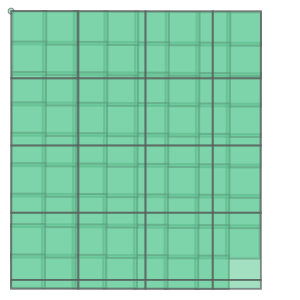

In [24]:
GeometryCollection([origin, mosaic_shifted, chunks_shapely])

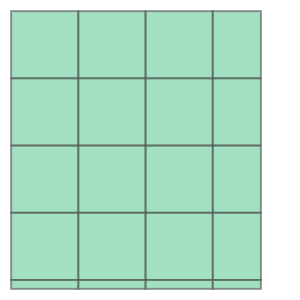

In [25]:
chunks_shapely

In [26]:
chunk_tiles = tile_chunk_intersections(mosaic_shifted, files[1:], transforms, chunks_shapely, chunk_slices)
chunk_tiles

{(0,
  0): [(PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0045.jpg'),
   array([[1.000000e+00, 0.000000e+00, 2.125000e+01],
          [0.000000e+00, 1.000000e+00, 3.820625e+03],
          [0.000000e+00, 0.000000e+00, 1.000000e+00]])), (PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0046.jpg'),
   array([[1.00000000e+00, 0.00000000e+00, 1.87484375e+03],
          [0.00000000e+00, 1.00000000e+00, 3.81000000e+03],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), (PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0047.jpg'),
   array([[1.00000000e+00, 0.00000000e+00, 3.72843750e+03],
          [0.00000000e+00, 1.00000000e+00, 3.79953125e+03],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), (PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0060.jpg'),
   array([[1.00000000e+00, 0.00000000e+00, 3.71781250e+03],
          [0.00000000e+00, 1.00000000e+00, 1.93140625e+03],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), (PosixPath('St

In [27]:
_fuse_func=partial(fuse_func, 
                   imload_func=_load_image,
                   dtype=np.uint8)

In [28]:
target_array = da.map_blocks(func=_fuse_func,
                             chunks=normalize_chunks(chunk_size, stitched_shape), 
                             input_tile_info=chunk_tiles,
                             dtype=np.uint8)

In [29]:
target_array.to_zarr("fused.zarr", overwrite=True)

Processing chunk at (0, 0)
Processing chunk at (0, 4096)
Processing chunk at (0, 8192)
Processing chunk at (0, 12288)
Processing chunk at (4096, 0)
Processing chunk at (4096, 4096)
Processing chunk at (4096, 8192)
Processing chunk at (4096, 12288)
Processing chunk at (8192, 0)
Processing chunk at (8192, 4096)
Processing chunk at (8192, 8192)
Processing chunk at (8192, 12288)
Processing chunk at (12288, 0)
Processing chunk at (12288, 4096)
Processing chunk at (12288, 8192)
Processing chunk at (12288, 12288)
Processing chunk at (16384, 0)
Processing chunk at (16384, 4096)
Processing chunk at (16384, 8192)
Processing chunk at (16384, 12288)


In [30]:
v = napari.Viewer()
v.add_image(da.from_zarr("fused.zarr"), name="Fused")

/home/jovyan/shared_volker/zarrgen/lib/python3.8/site-packages/napari/_vispy/vispy_image_layer.py:180: UserWarning: data shape (16925, 15222) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


<Image layer 'Fused' at 0x7f8dcc02c3d0>